# Generate full emissions portfolio from projected Kyoto gas baskets
Updated to include announcements as of COP26, 5/11/21. Including an analysis of full impact of Net Zero commitments on emissions.
# Part 2: harmonise data

In [1]:
import sys
stdout = sys.stdout

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pyam
import re
import seaborn as sns
from scipy.interpolate import interp1d, PchipInterpolator

<IPython.core.display.Javascript object>

In [3]:
from silicone.time_projectors import ExtendLatestTimeQuantile
import silicone.multiple_infillers as mi
import silicone.database_crunchers as dc
from silicone.utils import convert_units_to_MtCO2_equiv, _construct_consistent_values

In [4]:
version_no = "23"

# Import the data

In [5]:
co2 = "Emissions|CO2"
co2ind = "Emissions|CO2|Energy and Industrial Processes"
co2afolu = "Emissions|CO2|AFOLU"
variable = "Emissions|Kyoto Gases (AR6-GWP100)"
kyexaf = variable + "|Excluding CO2 AFOLU"
unit = "Mt CO2-equiv/yr"
co2unit = "Mt CO2/yr"
years = [2015] + list(range(2010, 2101, 10))

In [6]:
out_folder = f"../output/processed_files/{version_no}/"
sr15 = pyam.IamDataFrame(out_folder + "sr15_cleaned.csv")

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ..\output\processed_files\23\sr15_cleaned.csv


In [7]:
# Import data on expected projection of emissions
readin_data = pd.read_excel(
    "../input/Data_forextensions_EGR2023_master.xlsx", sheet_name="Extracted data EGR2023")
readin_data.columns = ["scenario", "model"] + list(readin_data.columns[2:5]) + ["unit"]

In [8]:
readin_data

,scenario,model,2015,2021,2030,unit
0,Min,Current policies,54347,56132,51755,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
1,Median,Current policies,54347,56132,56166,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
2,Max,Current policies,54347,56132,58835,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
3,Min,NDC case - unconditional,54347,56132,52861,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
4,Median,NDC case - unconditional,54347,56132,55640,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
5,Max,NDC case - unconditional,54347,56132,57110,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
6,Min,NDC case - conditional,54347,56132,49822,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
7,Median,NDC case - conditional,54347,56132,51879,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
8,Max,NDC case - conditional,54347,56132,54413,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...


In [9]:
variable = "Emissions|Kyoto Gases (AR6-GWP100)"
unit = "Mt CO2-equiv/yr"
raw_data = readin_data
raw_data["region"] = "World"
raw_data["unit"] = unit
raw_data["variable"] = variable
raw_data = pyam.IamDataFrame(raw_data)
raw_data = raw_data.interpolate(2020)
raw_data.data.head()

,model,scenario,region,variable,unit,year,value
0,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2015,54347.0
1,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2020,55834.5
2,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2021,56132.0
3,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,58835.0
4,Current policies,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2015,54347.0


In [10]:
# Import historical database
histall = pd.read_excel("../input/VanMarle2017Totals.xlsx", skiprows=1)
del histall["Unnamed: 13"]
del histall["Unnamed: 14"]
del histall["Unnamed: 15"]
histall = histall.rename(columns={"Scenario (History)": "Scenario"})
histall["Variable"] = histall["Variable"].str.replace("CMIP6 ", "")
histall["Scenario"] = "History"
histall["Region"] = histall["Region"].str.replace(".2", "").replace("R5OECD", "R5OECD90+EU")
histall = pyam.IamDataFrame(histall)

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [11]:
kyoto_gases_oddly = [
        'Emissions|C2F6', 
        'Emissions|CF4',
        'Emissions|CH4',
        'Emissions|CO2',
        'Emissions|HFC',
        'Emissions|SF6',
        'Emissions|N2O'
]
fgases = ["Emissions|HFC", 'Emissions|PFC|C2F6', 'EmissionsPFC|CF4', 'Emissions|SF6']
pfcs = ['Emissions|PFC|C2F6', 'Emissions|PFC|CF4']
histkyoto = _construct_consistent_values(
    variable, 
    kyoto_gases_oddly, 
    convert_units_to_MtCO2_equiv(histall.filter(
        region="World", variable=kyoto_gases_oddly), metric_name="AR6GWP100")
)
histall = histall.rename(variable={
    "Emissions|CF4":"Emissions|PFC|CF4", 'Emissions|C2F6':'Emissions|PFC|C2F6'})
histkyoto.timeseries()
histall = histall.append(histkyoto)
histnonafolu = histall.subtract(
    variable,
    co2afolu,
    name=kyexaf,
    ignore_units=True
)
histnonafolu = histnonafolu.data
histnonafolu["unit"] = unit
histnonafolu = pyam.IamDataFrame(histnonafolu)
histco2eni = histall.subtract(
    co2,
    co2afolu,
    name=co2ind,
    ignore_units=True
).data
histco2eni["unit"] = "Mt CO2/yr"
histco2eni = pyam.IamDataFrame(histco2eni)
histfgas = _construct_consistent_values(
    "Emissions|F-Gases", 
    fgases, 
    convert_units_to_MtCO2_equiv(
        histall.filter(region="World", variable=fgases), metric_name="AR6GWP100")
)
histpfc = _construct_consistent_values(
    "Emissions|PFC", 
    pfcs, 
    convert_units_to_MtCO2_equiv(
        histall.filter(region="World", variable=pfcs), metric_name="AR6GWP100")
)
histall = histall.append(histnonafolu).append(histco2eni).append(histfgas).append(histpfc)

In [12]:
# Ensure that the fgas totals work for the AR value we are using
fgas = "Emissions|F-Gases"
consistent_fgases = _construct_consistent_values(
    fgas, ["Emissions|SF6", "Emissions|PFC", "Emissions|HFC"], convert_units_to_MtCO2_equiv(
        histall.filter(variable=["Emissions|SF6", "Emissions|PFC*", "Emissions|HFC"]
                      ), metric_name="AR6GWP100"
    )
)
histall = histall.filter(variable=fgas, keep=False).append(consistent_fgases)

# Harmonize all values
We harmonise regional non-AFOLU Kyoto totals and global CO2|AFOLU. 

In [13]:
preharm_ts = raw_data.timeseries().reset_index()
preharm_ts.head()

,model,scenario,region,variable,unit,2015,2020,2021,2030
0,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,54347.0,55834.5,56132.0,58835.0
1,Current policies,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,54347.0,55834.5,56132.0,56166.0
2,Current policies,Min,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,54347.0,55834.5,56132.0,51755.0
3,NDC case - conditional,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,54347.0,55834.5,56132.0,54413.0
4,NDC case - conditional,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,54347.0,55834.5,56132.0,51879.0


In [14]:
# Harmonise using a scaling factor that goes to 1 in 2050
unity_year = 2050
def harmonize(df, var, harm_df, harm_years):
    harm_unit = harm_df.filter(variable=var).unit
    to_harm_unit = df.filter(variable=var).unit
    assert (harm_unit == to_harm_unit) or (harm_unit == ["Mt CO2-equiv/yr"]) or (
        (harm_unit == ["Mt NOx/yr"]) and (to_harm_unit == ["Mt NO2/yr"])
    ), "Invalid units {} (desired) and {} (current) for variable {}".format(
        harm_unit, to_harm_unit, var
    )
    if (harm_unit != to_harm_unit):
        print(
            "unit mismatch for  {} (desired) and {} (current) for variable {}".format(harm_unit, to_harm_unit, var)
        )
        if (harm_unit == ["Mt CO2-equiv/yr"]):
            df = pyam.convert_unit(df, current=to_harm_unit[0], to=harm_unit[0], context="AR6GWP100")
        print("Converted unit of {} to {}".format(var, df.filter(variable=var).unit))
    assert unity_year >= max(harm_years)
    canon2015 = harm_df.filter(year=2015, variable=var).data["value"]
    if len(canon2015) != 1:
        print(canon2015)
        raise ValueError
    ret = df.timeseries()
    canon2015 = canon2015[0]
    canon2010 = harm_df.filter(year=2010, variable=var).data["value"][0]
    if 2005 in harm_df.year:
        canon2005 = harm_df.filter(year=2005, variable=var).data["value"][0]
        ret[2005] = canon2005
    if 2000 in harm_df.year:
        canon2000 = harm_df.filter(year=2000, variable=var).data["value"][0]
        ret[2000] = canon2000
    assert df.variable==[var]
    ret[2010] = canon2010
    fractional_correction_all = ret[2015] / canon2015
    fractional_correction_use = fractional_correction_all
    ret[2015] = canon2015
    for year in [y for y in harm_years if y > 2015]:
        ret[year] = ret[year] / fractional_correction_use
        # Each decade we advance the harmonisation towards 1 linearly.
        next_year = min([y for y in harm_years if y > year] + [1000000])
        fractional_correction_use = 1 - (1-fractional_correction_all) * (unity_year - next_year) / (unity_year-2015)
    
    return pyam.IamDataFrame(ret)

In [15]:
# Harmonise the global projections from all scenarios which we want to reconstruct
harm_year_raw = [y for y in raw_data.year if y < unity_year]
harm_sing = []
for harm_var in [variable]:
    if not histall.filter(region="World", variable=harm_var).empty:
        harm_sing.append(
            harmonize(
                raw_data.filter(variable=harm_var, region="World"), 
                harm_var, 
                histall.filter(variable=harm_var, region="World"), 
                harm_year_raw
            )
        )
    else: 
        print("Variable {} not harmonised".format(harm_var))
harm_world = pyam.concat(harm_sing)

In [16]:
# We may need to apply the same scaling factors to the regions where the regional
# variables are not available in historic factors. 
harm_vars = [co2afolu, kyexaf]
def harmonise_regions_to_total(harm_regions, harm_world, harm_cols, harm_vars):
    # A function that takes the time series of regional values to harmonise, 
    # the harmonised IamDataFrame for the world (harm_world), the column names
    # in harm_regions to harmonise
    # list of values to harmonise (harm_var)
    harm_sing = []
    harm_world_ts = harm_world.timeseries().reset_index()
    for harm_var in harm_vars:
        print(harm_var)
        max_val_2015 = 1
        min_val_2015 = 1
        for (ind, (model, scenario)) in harm_regions[["model", "scenario"]
                                                    ].drop_duplicates().iterrows():
            ind_to_harm = (harm_regions["scenario"]==scenario) & (harm_regions["model"]==model) & (
                harm_regions["variable"]==harm_var)
            harm_ratio = (harm_world_ts.loc[
                (harm_world_ts["scenario"]==scenario) & (harm_world_ts["model"]==model) & 
                (harm_world_ts["variable"]==harm_var),
                harm_cols
            ].values / harm_regions.loc[
                ind_to_harm & (harm_regions["region"]=="World"),
                harm_cols
            ].values)[0]
            max_val_2015 = max([harm_ratio[1], max_val_2015])
            min_val_2015 = min([harm_ratio[1], min_val_2015])
            harm_regions.loc[ind_to_harm, harm_cols] = harm_regions.loc[
                ind_to_harm, harm_cols] * harm_ratio
            harm_sing.append(pyam.IamDataFrame(harm_regions.loc[ind_to_harm]))
        print(max_val_2015)
        print(min_val_2015)
    return harm_sing

In [17]:
assert np.allclose(
    histall.filter(variable=variable, year=harm_world.year).timeseries()[2015].iloc[0],
    harm_world.filter(variable=variable, year=harm_world.year).timeseries()[2015]
)

<AxesSubplot:title={'center':'region: World - variable: Emissions|Kyoto Gases (AR6-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

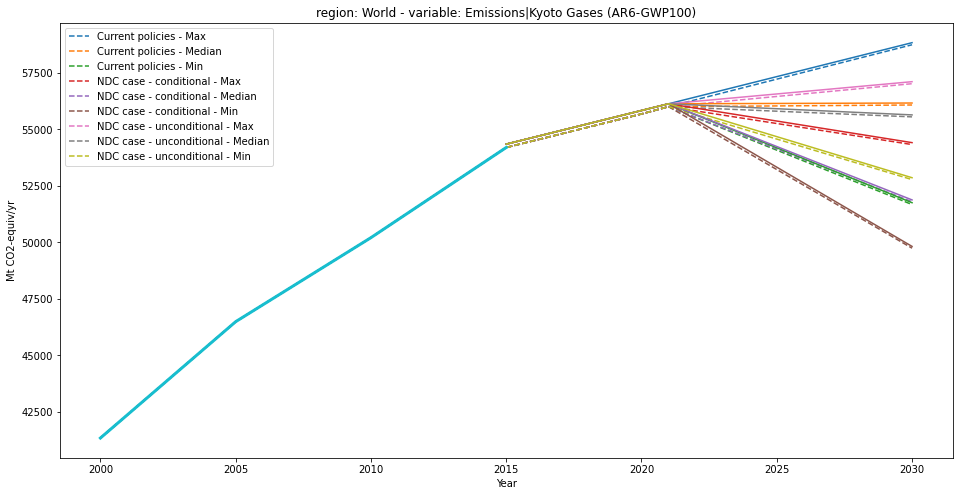

In [18]:
figure = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

harm_world.filter(variable=variable, region="World").plot(ax=ax, linestyle="--")
histall.filter(variable=variable, year=harm_world.year).plot(ax=ax, linestyle="-", linewidth=3)
raw_data.filter(variable=variable, region="World").plot(ax=ax, linestyle="-")

In [19]:
# Denote harmonisation in scenario names
harm_world = pyam.IamDataFrame(harm_world).data
harm_world["scenario"] = harm_world["scenario"] + "|Harmonized"
harm_world = pyam.IamDataFrame(harm_world)

In [20]:
# Since we don't have regional info in this case
harm_all = harm_world

In [21]:
# Harmonize sr15 too!
harmable_sr15_vars = [
    'Emissions|BC',
    'Emissions|CH4',
    'Emissions|CO',
    'Emissions|CO2',
    'Emissions|CO2|AFOLU',
    'Emissions|CO2|Energy and Industrial Processes',
    'Emissions|F-Gases',
    'Emissions|N2O',
    'Emissions|NH3',
    'Emissions|NOx',
    'Emissions|OC',
    'Emissions|Sulfur',
    'Emissions|VOC',
]
try:
    del harmed_sr15
except:
    pass
for harmvariable in harmable_sr15_vars:
    to_harm = sr15.filter(variable=harmvariable, scenario="SSP*", region="World")
    harmed_sr15_cmpt = harmonize(
        to_harm, harmvariable, histall.filter(region="World"), [2015, 2020, 2030, 2040, 2050])
    try:
        harmed_sr15 = harmed_sr15.append(harmed_sr15_cmpt)
    except: 
        harmed_sr15 = harmed_sr15_cmpt
# Some variables don't exist often enough in the SSP scenarios
fgas_harmvars = [
    'Emissions|SF6',
    'Emissions|HFC',
    'Emissions|PFC',
    'Emissions|PFC|C2F6',
    'Emissions|PFC|CF4'
]
for harmvariable in fgas_harmvars:
    to_harm = sr15.filter(variable=harmvariable, region="World")
    harmed_sr15_cmpt = harmonize(to_harm, harmvariable, histall.filter(region="World"), [2015, 2020, 2030, 2040, 2050])
    harmed_sr15 = harmed_sr15.append(harmed_sr15_cmpt)
# And the gases that exist as subcomponents of HFCs are impossible to harmonise and simply appended. 
harmed_sr15 = harmed_sr15.append(sr15.filter(region="World", variable="*|HFC|*"))

unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt CO2-equiv/yr'] (desired) and ['kt HFC134a-equiv/yr'] (current) for variable Emissions|HFC
Converted unit of Emissions|HFC to ['Mt CO2-equiv/yr']
unit mismatch for  ['Mt CO2-equiv/yr'] (desired) and ['kt CF4-equiv/yr'] (current) for variable Emissions|PFC
Converted unit of Emissions|PFC to ['Mt CO2-equiv/yr']


In [22]:
# Introduce the Kyoto gas total with AR6
kyoto_gases = [
    'Emissions|CH4',
    'Emissions|CO2',
    'Emissions|F-Gases',
    'Emissions|N2O'
]
sr15_ky_ar6 = _construct_consistent_values(
    variable, 
    kyoto_gases, 
    convert_units_to_MtCO2_equiv(harmed_sr15.filter(
        region="World", variable=kyoto_gases, scenario="SSP*"), metric_name="AR6GWP100")
)

In [23]:
# deleteme
harmed_sr15.filter(
        region="World", variable=kyoto_gases, scenario="SSP*").unit

['Mt CH4/yr', 'Mt CO2/yr', 'Mt CO2-equiv/yr', 'kt N2O/yr']

In [24]:
assert len(sr15_ky_ar6.timeseries().loc[:, 2015].drop_duplicates().values) == 1

In [25]:
assert np.allclose(
    histkyoto.filter(year=2015).data.value, 
    sr15_ky_ar6.filter(year=2015).data.value.unique()
)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|Kyoto Gases (AR6-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

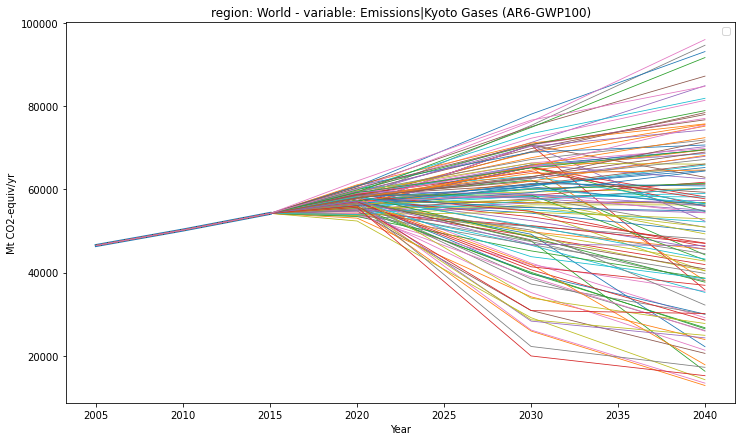

In [26]:
plt.figure(figsize=(12, 7))
ax = plt.subplot()
histkyoto.filter(year=[2005, 2010, 2015]).plot(ax=ax, linewidth=3)
sr15_ky_ar6.filter(year=[2005, 2010, 2015, 2020, 2030, 2040]).plot(ax=ax, linewidth=0.8)

In [27]:
harmed_sr15 = harmed_sr15.append(sr15_ky_ar6)

In [28]:
harmed_sr15.timeseries()

2000  \
model             scenario               region variable               unit                         
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|HFC          Mt CO2-equiv/yr   177.1600   
                                                Emissions|HFC|HFC125   kt HFC125/yr           NaN   
                                                Emissions|HFC|HFC134a  kt HFC134a/yr          NaN   
                                                Emissions|HFC|HFC143a  kt HFC143a/yr          NaN   
                                                Emissions|HFC|HFC227ea kt HFC227ea/yr         NaN   
...                                                                                           ...   
WITCH-GLOBIOM 4.2 ADVANCE_Reference      World  Emissions|HFC|HFC23    kt HFC23/yr            NaN   
                                                Emissions|HFC|HFC32    kt HFC32/yr            NaN   
                                                Emissions|HFC|HFC43-10 kt HFC4310mee/yr       NaN   
                                                Emissions|PFC          Mt CO2-equiv/yr   107.8116   
                                                Emissions|SF6          kt SF6/yr           4.8600   

                                                                                             2005  \
model             scenario               region variable               unit                         
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|HFC          Mt CO2-equiv/yr   296.6200   
                                                Emissions|HFC|HFC125   kt HFC125/yr           NaN   
                                                Emissions|HFC|HFC134a  kt HFC134a/yr          NaN   
                                                Emissions|HFC|HFC143a  kt HFC143a/yr          NaN   
                                                Emissions|HFC|HFC227ea kt HFC227ea/yr         NaN   
...                                                                                           ...   
WITCH-GLOBIOM 4.2 ADVANCE_Reference      World  Emissions|HFC|HFC23    kt HFC23/yr        10.8120   
                                                Emissions|HFC|HFC32    kt HFC32/yr        10.9930   
                                                Emissions|HFC|HFC43-10 kt HFC4310mee/yr    1.0000   
                                                Emissions|PFC          Mt CO2-equiv/yr   104.7022   
                                                Emissions|SF6          kt SF6/yr           5.7900   

                                                                                               2010  \
model             scenario               region variable               unit                           
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|HFC          Mt CO2-equiv/yr   597.150000   
                                                Emissions|HFC|HFC125   kt HFC125/yr       30.576302   
                                                Emissions|HFC|HFC134a  kt HFC134a/yr     182.725482   
                                                Emissions|HFC|HFC143a  kt HFC143a/yr      25.150486   
                                                Emissions|HFC|HFC227ea kt HFC227ea/yr     10.447885   
...                                                                                             ...   
WITCH-GLOBIOM 4.2 ADVANCE_Reference      World  Emissions|HFC|HFC23    kt HFC23/yr         9.522000   
                                                Emissions|HFC|HFC32    kt HFC32/yr        17.942000   
                                                Emissions|HFC|HFC43-10 kt HFC4310mee/yr    1.020500   
                                                Emissions|PFC          Mt CO2-equiv/yr    90.971600   
                                                Emissions|SF6          kt SF6/yr           6.960000   

                                                                                               2015  \
model             scen

In [29]:
# Unify the regional breakdown of emissions?
"""
def unify_regions_to_totals(df):
    to_return = df.data
    for var in df.variable:
        aggcheck = df.check_aggregate_region(var)
        if aggcheck is not None:
            aggcheck = aggcheck.rename(columns={"region":"whole"}).reset_index()
        else:
            print("no unification possible for {}".format(var))
            continue
        aggcheck["ratio"] = aggcheck.loc[:, "whole"] / aggcheck.loc[:, "subregions"]
        
        for ind, (model, scenario, year) in aggcheck[["model", "scenario", "year"]].iterrows():
            to_return.loc[
                (to_return["region"]!="World") & (to_return["model"]==model) 
                & (to_return["scenario"]==scenario)
                & (to_return["variable"]==var) & (to_return["year"]==year), "value"
            ] *= aggcheck.loc[ind, "ratio"]
        print("Unified {} with ratio {}".format(
            var, aggcheck.loc[ind, "ratio"]))
    return pyam.IamDataFrame(to_return)

histall_unify = unify_regions_to_totals(histall)
"""
histall_unify = histall

In [30]:
harmed_sr15.filter(variable="Emissions|HFC|HFC*").variable

['Emissions|HFC|HFC125',
 'Emissions|HFC|HFC134a',
 'Emissions|HFC|HFC143a',
 'Emissions|HFC|HFC227ea',
 'Emissions|HFC|HFC23',
 'Emissions|HFC|HFC32',
 'Emissions|HFC|HFC43-10',
 'Emissions|HFC|HFC245fa']

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


(2005.0, 2060.0)

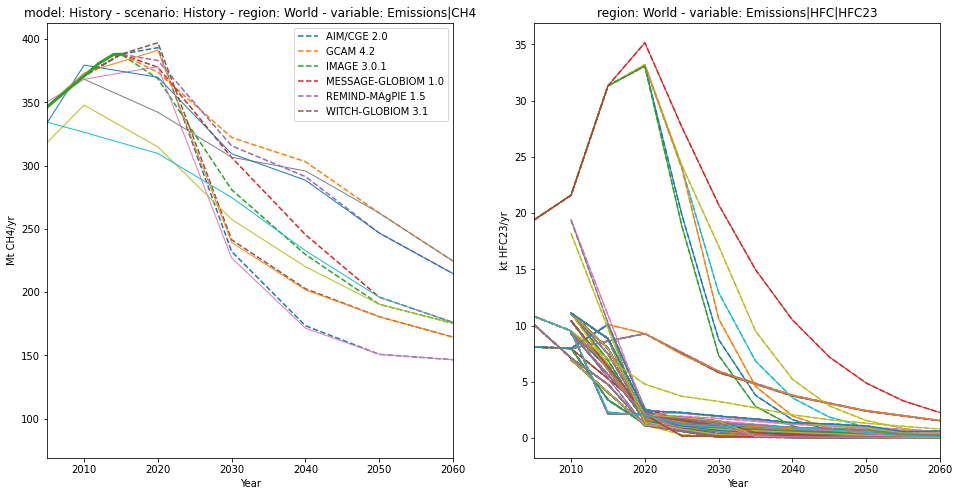

In [31]:
figure = plt.figure(figsize=(16, 8))
ax = plt.subplot(121)
harmed_sr15.filter(variable="Emissions|CH4", scenario="SSP1-2*", region="World").plot(ax=ax, linestyle="--")
sr15.filter(variable="Emissions|CH4", scenario="SSP1-2*", region="World").plot(ax=ax, linewidth=1)
histall.filter(variable="Emissions|CH4", region="World").plot(ax=ax, linewidth=3)
plt.xlim([2005, 2060])
ax = plt.subplot(122)
harmed_sr15.filter(variable="Emissions|HFC|HFC23", region="World").plot(ax=ax, linestyle="--")
sr15.filter(variable="Emissions|HFC|HFC23", region="World").plot(ax=ax, linewidth=1)
plt.xlim([2005, 2060])

Text(2000, 20000, 'expect change if correcting regions')

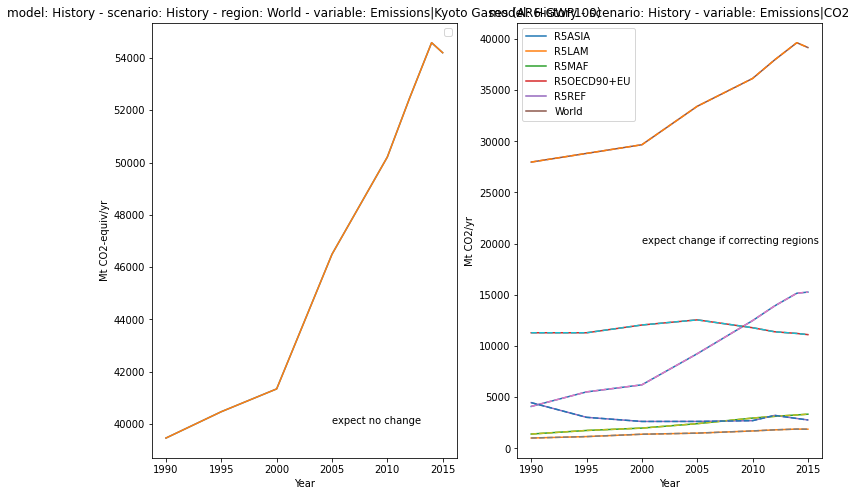

In [32]:
ch4 = "Emissions|CH4"
plt.figure(figsize=(12, 8))
ax = plt.subplot(121)
histall_unify.filter(variable=variable).plot(ax=ax)
histall.filter(variable=variable).plot(ax=ax)
plt.text(x=2005, y=40000, s="expect no change")
ax = plt.subplot(122)
histall_unify.filter(variable=co2).plot(ax=ax)
histall.filter(variable=co2).plot(ax=ax, linestyle="--")
plt.text(x=2000, y=20000, s="expect change if correcting regions")

In [33]:
co2ind

'Emissions|CO2|Energy and Industrial Processes'

In [34]:
histall.timeseries().head()

1990         1995  \
model   scenario region variable      unit                                  
History History  R5ASIA Emissions|BC  Mt BC/yr      2.943000     3.213000   
                        Emissions|CH4 Mt CH4/yr    92.858640    99.653799   
                        Emissions|CO  Mt CO/yr    299.179721   299.379993   
                        Emissions|CO2 Mt CO2/yr  4089.048733  5507.514650   
                        Emissions|NH3 Mt NH3/yr    23.803027    25.299512   

                                                        2000         2005  \
model   scenario region variable      unit                                  
History History  R5ASIA Emissions|BC  Mt BC/yr      3.177000     3.910000   
                        Emissions|CH4 Mt CH4/yr   104.168651   124.903493   
                        Emissions|CO  Mt CO/yr    308.268244   354.636749   
                        Emissions|CO2 Mt CO2/yr  6200.737158  9237.420318   
                        Emissions|NH3 Mt NH3/yr    26.153645    28.538322   

                                                         2010          2012  \
model   scenario region variable      unit                                    
History History  R5ASIA Emissions|BC  Mt BC/yr       4.529000      4.702000   
                        Emissions|CH4 Mt CH4/yr    145.036835    154.013485   
                        Emissions|CO  Mt CO/yr     383.928799    399.037011   
                        Emissions|CO2 Mt CO2/yr  12471.213053  13912.271152   
                        Emissions|NH3 Mt NH3/yr     30.858288     31.744082   

                                                         2014          2015  
model   scenario region variable      unit                                   
History History  R5ASIA Emissions|BC  Mt BC/yr       4.881000      4.798000  
                        Emissions|CH4 Mt CH4/yr    159.081233    157.701951  
                        Emissions|CO  Mt CO/yr     445.856031    411.649982  
                        Emissions|CO2 Mt CO2/yr  15148.761291  15258.781557  
                        Emissions|NH3 Mt NH3/yr     32.725085     32.720584

In [35]:
histall.variable

['Emissions|BC',
 'Emissions|CH4',
 'Emissions|CO',
 'Emissions|CO2',
 'Emissions|CO2|AFOLU',
 'Emissions|CO2|Energy and Industrial Processes',
 'Emissions|F-Gases',
 'Emissions|HFC',
 'Emissions|Kyoto Gases (AR6-GWP100)',
 'Emissions|Kyoto Gases (AR6-GWP100)|Excluding CO2 AFOLU',
 'Emissions|N2O',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|OC',
 'Emissions|PFC',
 'Emissions|PFC|C2F6',
 'Emissions|PFC|CF4',
 'Emissions|SF6',
 'Emissions|Sulfur',
 'Emissions|VOC']

In [36]:
# harmonise the regional variables in SR1.5 where historic regional variables exist, 
# unify them where they don't
regional_var = [var for var in harmable_sr15_vars 
                if var in histall_unify.filter(region="R5ASIA").variable]
non_region_var = [var for var in harmable_sr15_vars if var not in regional_var]
non_region_var

['Emissions|CO2|AFOLU',
 'Emissions|CO2|Energy and Industrial Processes',
 'Emissions|F-Gases',
 'Emissions|N2O']

In [37]:
regional_var

['Emissions|BC',
 'Emissions|CH4',
 'Emissions|CO',
 'Emissions|CO2',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|OC',
 'Emissions|Sulfur',
 'Emissions|VOC']

In [38]:
orig_ssps = sr15.filter(scenario="SSP*")
regional_ssps = orig_ssps.filter(region="World", keep=False).append(harmed_sr15)

In [39]:
harmed_sr15_regions_to_tot = harmonise_regions_to_total(
    orig_ssps.timeseries().reset_index(), harmed_sr15, years, non_region_var
)
harmed_sr15_regions_to_tot = pyam.concat(harmed_sr15_regions_to_tot)

Emissions|CO2|AFOLU
1.0360011363142123
0.452564970520626
Emissions|CO2|Energy and Industrial Processes
1.055641710413873
0.9900884851443414
Emissions|F-Gases
1.1777069785711167
0.9179235046300732
Emissions|N2O
1.2041121950707223
0.9878529136874571


In [40]:
harmed_sr15_regions_to_tot.check_aggregate_region(co2afolu)

pyam.core - INFO: `Emissions|CO2|AFOLU` - 43 of 1492 rows are not aggregates of subregions


region  \
model               scenario region variable            unit      year                
IMAGE 3.0.1         SSP1-34  World  Emissions|CO2|AFOLU Mt CO2/yr 2040     6.047110   
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  3517.440000   
                                                                  2020  2069.697465   
                                                                  2060 -3515.194641   
                    SSP2-26  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  3517.440000   
                                                                  2020  2691.496578   
REMIND-MAgPIE 1.5   SSP1-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2005  5702.000000   
                                                                  2010  3241.079398   
                                                                  2015  3517.440000   
                                                                  2020  1932.043942   
                                                                  2030  1724.608274   
                                                                  2040  2765.679711   
                                                                  2050  2418.000000   
                                                                  2060  -728.700000   
                                                                  2070 -1242.000000   
                                                                  2080 -1892.000000   
                                                                  2090 -2617.000000   
                                                                  2100 -2862.000000   
                    SSP1-26  World  Emissions|CO2|AFOLU Mt CO2/yr 2100     9.658000   
                    SSP2-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2005  5538.000000   
                                                                  2010  3241.079398   
                                                                  2015  3517.440000   
                                                                  2020  3140.784952   
                                                                  2030  3854.522720   
                                                                  2040  4268.652529   
                                                                  2050  1314.000000   
                                                                  2060  1148.000000   
                                                                  2070    30.980000   
                                                                  2080  -188.800000   
                                                                  2090   345.200000   
                                                                  2100  -320.600000   
                    SSP5-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2005  5733.000000   
                                                                  2010  3241.079398   
                                                                  2015  3517.440000   
                                                                  2020  1692.419683   
                                                                  2030  1878.586249   
                                                                  2040  4702.885348   
                                                                  2050  5147.000000   
                                                                  2060  1317.000000   
                                                                  2070   859.900000   
                                                                  2080   704.400000   
                                                                  2090  -102.300000   
                                                                  2100 -1201.000000   

                                                                         subregions  
model               scenario region variable            unit      year     

In [41]:
orig_ssps.check_aggregate_region(co2afolu).head()

pyam.core - INFO: `Emissions|CO2|AFOLU` - 43 of 1492 rows are not aggregates of subregions


region  \
model               scenario region variable            unit      year                
IMAGE 3.0.1         SSP1-34  World  Emissions|CO2|AFOLU Mt CO2/yr 2040     5.857696   
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5073.319658   
                                                                  2020  2985.192878   
                                                                  2060 -3515.194641   
                    SSP2-26  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5799.614352   

                                                                         subregions  
model               scenario region variable            unit      year               
IMAGE 3.0.1         SSP1-34  World  Emissions|CO2|AFOLU Mt CO2/yr 2040     5.857864  
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5074.384433  
                                                                  2020  2987.322928  
                                                                  2060 -3515.148491  
                    SSP2-26  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5800.869378

In [42]:
regional_var

['Emissions|BC',
 'Emissions|CH4',
 'Emissions|CO',
 'Emissions|CO2',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|OC',
 'Emissions|Sulfur',
 'Emissions|VOC']

In [43]:
harmed_sr15_regions = harmed_sr15_regions_to_tot
sr15_harm_years = [2010, 2015, 2020, 2030, 2040, 2050]
prop_harmed_sr15_regions = []
regions = [r for r in harmed_sr15_regions_to_tot.region if r != "World"]
for var in regional_var:
    for region in regions:
        prop_harmed_sr15_regions.append(
            harmonize(
                regional_ssps.filter(variable=var, region=region), 
                var, 
                histall_unify.filter(variable=var, region=region),
                sr15_harm_years
            )
        )
harmed_sr15_regions = pyam.concat(prop_harmed_sr15_regions).append(
    harmed_sr15_regions).filter(year=2005, keep=False)

unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']


pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


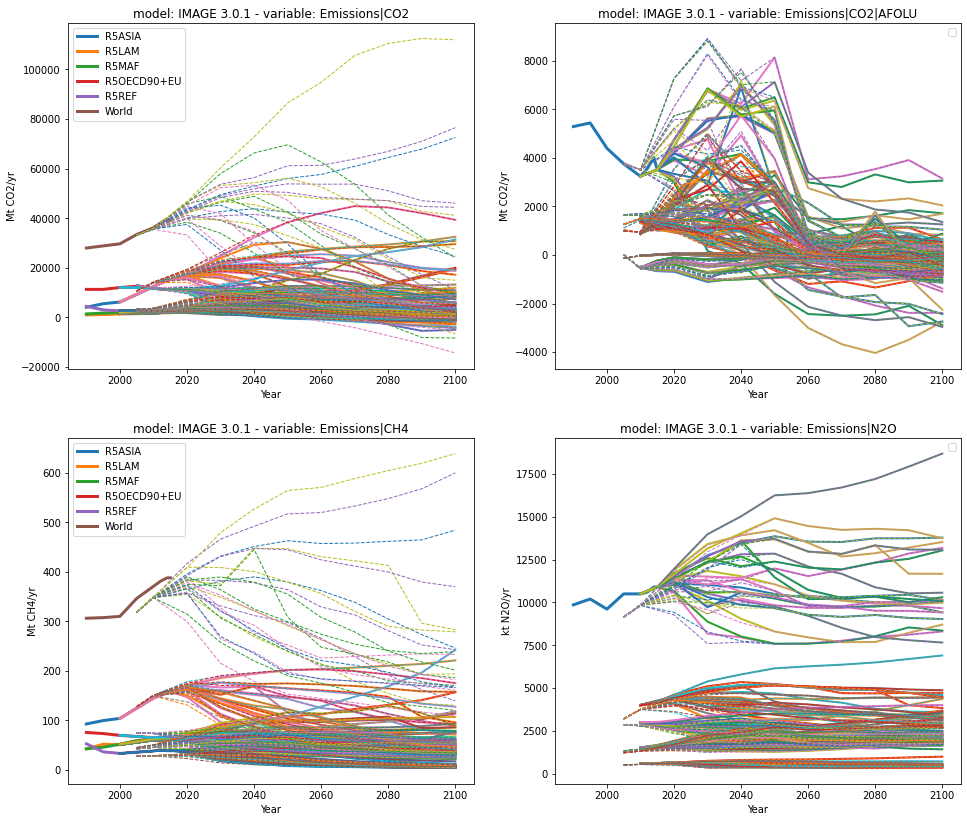

In [44]:
to_plot = [co2, co2afolu, ch4, "Emissions|N2O"]
plt.figure(figsize=(16, 14))
for i in range(4):
    var = to_plot[i]
    ax=plt.subplot(2, 2, i+1)
    histall.filter(variable=var).plot(ax=ax, linestyle="-", linewidth=3)
    harmed_sr15_regions.filter(variable=var, model="IMAGE*").plot(ax=ax, linewidth=2)
    orig_ssps.filter(variable=var, model="IMAGE*").plot(ax=ax, linestyle="--", linewidth=1)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: IMAGE 3.0.1 - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

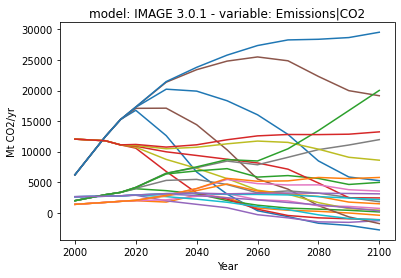

In [45]:
harmed_sr15_regions.filter(variable=co2, model="IMAGE*", scenario="SSP2*").plot()

In [46]:
harmed_sr15_regions.check_aggregate_region(var).head(20)

pyam.core - INFO: `Emissions|N2O` - 296 of 1386 rows are not aggregates of subregions


region  \
model               scenario region variable      unit      year                 
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|N2O kt N2O/yr 2010  10500.000000   
                                                            2015  10900.000000   
                                                            2020  10883.472543   
                                                            2030   9482.762055   
                                                            2040   8449.127435   
                                                            2050   7267.121686   
                    SSP1-26  World  Emissions|N2O kt N2O/yr 2010  10500.000000   
                                                            2015  10900.000000   
                                                            2020  11039.974693   
                                                            2030  10163.271188   
                                                            2040   9453.296235   
                                                            2050   8358.241294   
                    SSP1-34  World  Emissions|N2O kt N2O/yr 2010  10500.000000   
                                                            2015  10900.000000   
                                                            2020  11110.093773   
                                                            2030  10457.613336   
                                                            2040   9982.140539   
                                                            2050   9215.353819   
                                                            2060   8482.590217   
                    SSP1-45  World  Emissions|N2O kt N2O/yr 2010  10500.000000   

                                                                    subregions  
model               scenario region variable      unit      year                
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|N2O kt N2O/yr 2010  10345.464481  
                                                            2015  10730.483200  
                                                            2020  10705.104776  
                                                            2030   9342.077294  
                                                            2040   8383.048640  
                                                            2050   7253.431986  
                    SSP1-26  World  Emissions|N2O kt N2O/yr 2010  10345.701962  
                                                            2015  10733.170662  
                                                            2020  10864.435140  
                                                            2030  10023.745449  
                                                            2040   9387.474522  
                                                            2050   8341.281294  
                    SSP1-34  World  Emissions|N2O kt N2O/yr 2010  10345.702208  
                                                            2015  10734.257834  
                                                            2020  10935.697910  
                                                            2030  10318.561768  
                                                            2040   9916.424473  
                                                            2050   9196.433819  
                                                            2060   8481.660216  
                    SSP1-45  World  Emissions|N2O kt N2O/yr 2010  10345.701863

In [47]:
sr15_region_ky_ar6 = _construct_consistent_values(
    variable, 
    kyoto_gases, 
    convert_units_to_MtCO2_equiv(harmed_sr15_regions.filter(
        variable=kyoto_gases, scenario="SSP*"), metric_name="AR6GWP100")
)

In [48]:
check = sr15_region_ky_ar6.filter(region="R5ASIA").timeseries()[2015].values
assert (max(check) - min (check)) / np.mean(check) < 0.02

In [49]:
harmed_sr15_regions = harmed_sr15_regions.append(sr15_region_ky_ar6)

In [50]:
harmed_sr15_regions.variable

['Emissions|BC',
 'Emissions|CH4',
 'Emissions|CO',
 'Emissions|CO2',
 'Emissions|CO2|AFOLU',
 'Emissions|CO2|Energy and Industrial Processes',
 'Emissions|F-Gases',
 'Emissions|Kyoto Gases (AR6-GWP100)',
 'Emissions|N2O',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|OC',
 'Emissions|Sulfur',
 'Emissions|VOC']

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: R5OECD90+EU - variable: Emissions|Kyoto Gases (AR6-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

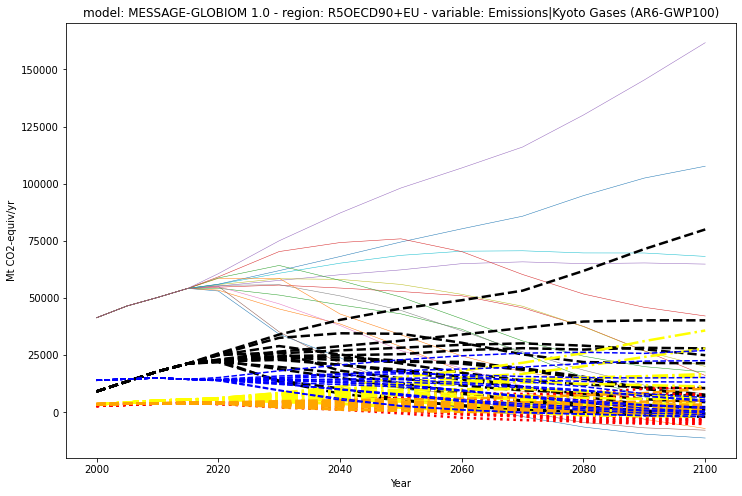

In [51]:
plt.figure(figsize=(12, 8))
model="MESSAGE*"
ax=plt.subplot()
harmed_sr15.filter(model=model, variable=variable, region="World").plot(ax=ax, linewidth=0.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R5ASIA").plot(
    ax=ax, linestyle="--", color="black", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R5LAM").plot(
    ax=ax, linestyle=":", color="red", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R5MAF").plot(
    ax=ax, linestyle="-.", color="yellow", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R5REF").plot(
    ax=ax, linestyle="--", color="orange", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R5OECD90+EU").plot(
    ax=ax, linestyle="--", color="blue", linewidth=1.5)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: R5OECD90+EU - variable: Emissions|CO2|AFOLU'}, xlabel='Year', ylabel='Mt CO2/yr'>

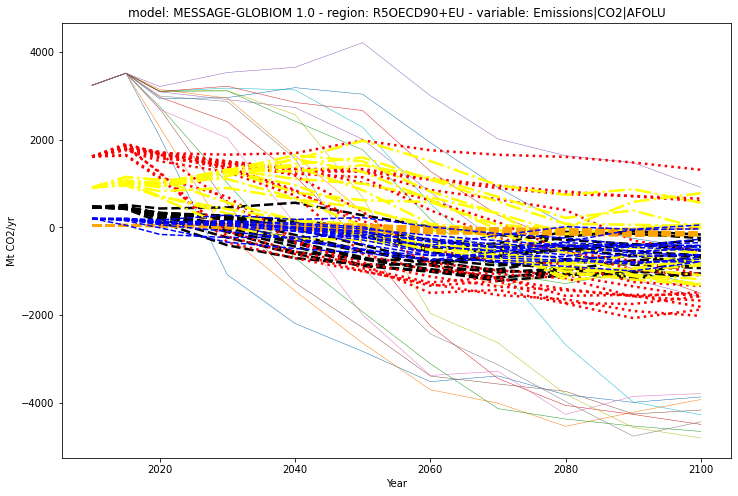

In [52]:
plt.figure(figsize=(12, 8))
model="MESSAGE*"
ax=plt.subplot()
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="World").plot(ax=ax, linewidth=0.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R5ASIA").plot(
    ax=ax, linestyle="--", color="black", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R5LAM").plot(
    ax=ax, linestyle=":", color="red", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R5MAF").plot(
    ax=ax, linestyle="-.", color="yellow", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R5REF").plot(
    ax=ax, linestyle="--", color="orange", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R5OECD90+EU").plot(
    ax=ax, linestyle="--", color="blue", linewidth=1.5)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|SF6'}, xlabel='Year', ylabel='kt SF6/yr'>

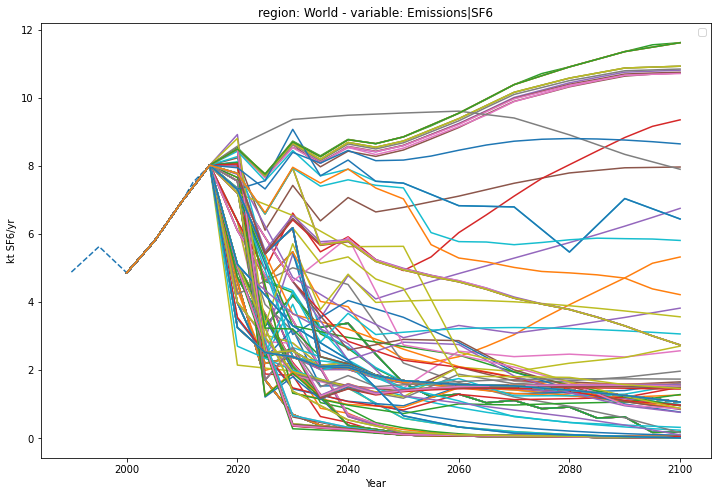

In [53]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
histall.filter(variable="*SF6").plot(ax=ax, linestyle="--")
harmed_sr15.filter(variable="*SF6", region="World").plot(ax=ax)

In [54]:
harmed_sr15_regions.filter(model=model, variable=co2afolu).check_aggregate_region(co2afolu)

pyam.core - INFO: `Emissions|CO2|AFOLU` - 5 of 165 rows are not aggregates of subregions


region  \
model               scenario region variable            unit      year                
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  3517.440000   
                                                                  2020  2069.697465   
                                                                  2060 -3515.194641   
                    SSP2-26  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  3517.440000   
                                                                  2020  2691.496578   

                                                                         subregions  
model               scenario region variable            unit      year               
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  3518.178231  
                                                                  2020  2071.174274  
                                                                  2060 -3515.148491  
                    SSP2-26  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  3518.201167  
                                                                  2020  2693.019216

In [55]:
sr15.filter(model=model, variable=co2afolu, scenario="SSP*").check_aggregate_region(co2afolu)

pyam.core - INFO: `Emissions|CO2|AFOLU` - 5 of 180 rows are not aggregates of subregions


region  \
model               scenario region variable            unit      year                
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5073.319658   
                                                                  2020  2985.192878   
                                                                  2060 -3515.194641   
                    SSP2-26  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5799.614352   
                                                                  2020  4437.784919   

                                                                         subregions  
model               scenario region variable            unit      year               
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5074.384433  
                                                                  2020  2987.322928  
                                                                  2060 -3515.148491  
                    SSP2-26  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5800.869378  
                                                                  2020  4440.295469

In [56]:
harmed_sr15.filter(variable="*PFC|*").timeseries()

2000  \
model                       scenario                   region variable           unit               
IEA World Energy Model 2017 Faster Transition Scenario World  Emissions|PFC|C2F6 kt C2F6/yr  2.85   
                                                              Emissions|PFC|CF4  kt CF4/yr   9.82   
IMAGE 3.0.1                 IMA15-AGInt                World  Emissions|PFC|C2F6 kt C2F6/yr  2.85   
                                                              Emissions|PFC|CF4  kt CF4/yr   9.82   
                            IMA15-Def                  World  Emissions|PFC|C2F6 kt C2F6/yr  2.85   
                                                              Emissions|PFC|CF4  kt CF4/yr   9.82   
                            IMA15-Eff                  World  Emissions|PFC|C2F6 kt C2F6/yr  2.85   
                                                              Emissions|PFC|CF4  kt CF4/yr   9.82   
                            IMA15-LiStCh               World  Emissions|PFC|C2F6 kt C2F6/yr  2.85   
                                                              Emissions|PFC|CF4  kt CF4/yr   9.82   
                            IMA15-LoNCO2               World  Emissions|PFC|C2F6 kt C2F6/yr  2.85   
                                                              Emissions|PFC|CF4  kt CF4/yr   9.82   
                            IMA15-Pop                  World  Emissions|PFC|C2F6 kt C2F6/yr  2.85   
                                                              Emissions|PFC|CF4  kt CF4/yr   9.82   
                            IMA15-RenElec              World  Emissions|PFC|C2F6 kt C2F6/yr  2.85   
                                                              Emissions|PFC|CF4  kt CF4/yr   9.82   
                            IMA15-TOT                  World  Emissions|PFC|C2F6 kt C2F6/yr  2.85   
                                                              Emissions|PFC|CF4  kt CF4/yr   9.82   

                                                                                              2005  \
model                       scenario                   region variable           unit                
IEA World Energy Model 2017 Faster Transition Scenario World  Emissions|PFC|C2F6 kt C2F6/yr   2.26   
                                                              Emissions|PFC|CF4  kt CF4/yr   10.39   
IMAGE 3.0.1                 IMA15-AGInt                World  Emissions|PFC|C2F6 kt C2F6/yr   2.26   
                                                              Emissions|PFC|CF4  kt CF4/yr   10.39   
                            IMA15-Def                  World  Emissions|PFC|C2F6 kt C2F6/yr   2.26   
                                                              Emissions|PFC|CF4  kt CF4/yr   10.39   
                            IMA15-Eff                  World  Emissions|PFC|C2F6 kt C2F6/yr   2.26   
                                                              Emissions|PFC|CF4  kt CF4/yr   10.39   
                            IMA15-LiStCh               World  Emissions|PFC|C2F6 kt C2F6/yr   2.26   
                                                              Emissions|PFC|CF4  kt CF4/yr   10.39   
                            IMA15-LoNCO2               World  Emissions|PFC|C2F6 kt C2F6/yr   2.26   
                                                              Emissions|PFC|CF4  kt CF4/yr   10.39   
                            IMA15-Pop                  World  Emissions|PFC|C2F6 kt C2F6/yr   2.26   
                                                              Emissions|PFC|CF4  kt CF4/yr   10.39   
                            IMA15-RenElec              World  Emissions|PFC|C2F6 kt C2F6/yr   2.26   
                                                              Emissions|PFC|CF4  kt CF4/yr   10.39   
                            IMA15-TOT                  World  Emissions|PFC|C2F6 kt C2F6/yr   2.26   
                                                              Emissions|PFC|CF4  kt CF4/yr   10.39   

                               

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'scenario: SSP2-34 - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

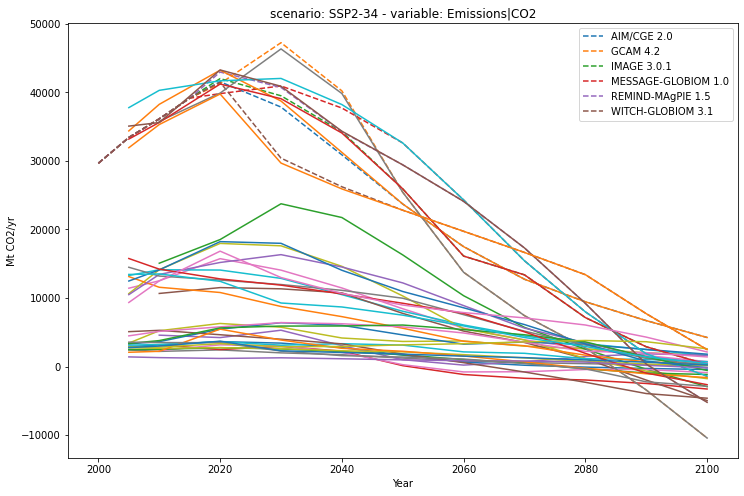

In [57]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
harmed_sr15.filter(variable=co2, scenario=harmed_sr15.scenario[132:133]).plot(ax=ax, linestyle="--")
sr15.filter(variable=co2, scenario=harmed_sr15.scenario[132:133]).plot(ax=ax)

# Plot distribution of 2030 values

In [58]:
harm_all_but_old_names = harm_all.filter(variable=variable, region="World", year=2030).data
harm_all_but_old_names["scenario"] = harm_all_but_old_names["scenario"].str.replace(
    "\|Harmonized", "")
compare_harms_ky = pd.merge(
    raw_data.filter(variable=variable, region="World", year=2030).data,
    harm_all_but_old_names,
    on=("model", "scenario", "region", "year", "variable", "unit"),
    how="outer"
)
compare_harms_ky = compare_harms_ky.rename(columns={"value_x": "Unharmonized", "value_y": "Harmonized"})

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 20.80000000000002, 'Unharmonized 2030 Kyoto total (Mt CO2)')

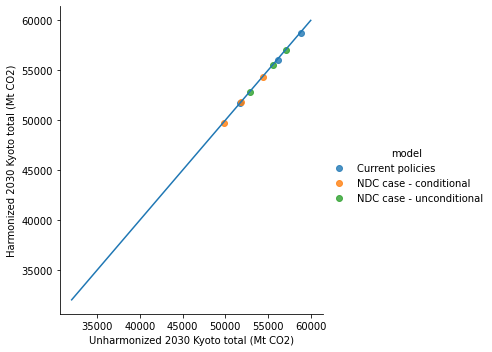

In [59]:
sns.lmplot(x='Unharmonized', y='Harmonized', data=compare_harms_ky, hue='model', fit_reg=False)
plt.plot([32000, 60000], [32000, 60000])
plt.ylabel("Harmonized 2030 Kyoto total (Mt CO2)")
plt.xlabel("Unharmonized 2030 Kyoto total (Mt CO2)")

In [60]:
compare_harms_ky = compare_harms_ky.melt(
    [c for c in compare_harms_ky.columns if c not in ["Unharmonized", "Harmonized"]], var_name="Harmonization"
)
compare_harms_ky.head()

,model,scenario,region,variable,unit,year,Harmonization,value
0,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,58835.0
1,Current policies,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,56166.0
2,Current policies,Min,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,51755.0
3,NDC case - conditional,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,54413.0
4,NDC case - conditional,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,51879.0


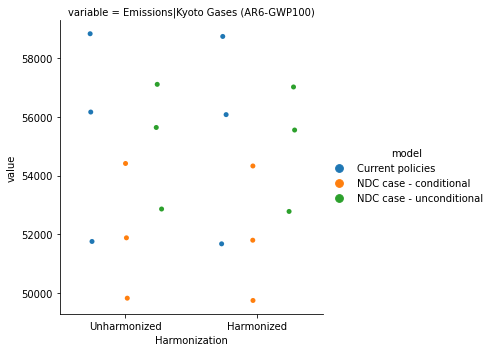

In [61]:
sns.catplot(x="Harmonization", y="value", col="variable", hue="model", 
            data=compare_harms_ky, dodge=True)

# Output harmonised values

In [62]:
if not os.path.exists(out_folder):
    os.mkdir(out_folder)
harm_all.to_csv(out_folder + f"harm_all_{version_no}.csv")
harmed_sr15.to_csv(out_folder + "sr15_cleaned_harmed.csv")
harmed_sr15_regions.to_csv(out_folder + "sr15_cleaned_harmed_regions.csv")